## Goals: Training the _Final_ Models

This notebook trains the model on the full _baseline_dataset_ for the final prediction on evaluation data.

Here, we train a model designed to generalize across water stations in Brazil and France. However, you are not required to follow this approach and may opt to train separate models for different geographic _regions_.

This baseline model training example utilizes all available features, with hyperparameters chosen for quick execution rather than optimization. For hyperparameter tuning and feature selection explorations, refer to the `02_exploration` folder.

> **Note:** This notebook requires outputs from the `00 Preprocessing` notebooks.

<img src="../images/notebook-3.png" alt="Experiment Diagram" style="width:75%; text-align:center;" />

### 1. Data Import and Setup

This section imports the necessary libraries, sets up environment paths, and includes custom utility functions.


In [1]:
import os
import sys

import joblib
import numpy as np
import pandas as pd
import lightgbm as lgb
import tensorflow as tf
import lightgbm as lgb

from interpret.glassbox import ExplainableBoostingRegressor
from mapie.regression import MapieQuantileRegressor
from quantile_forest import RandomForestQuantileRegressor

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..")))

from src.utils.model import (
    split_dataset,
    compare_models_per_station,
    create_deep_model,
    standardize_prediction_intervals,
    standardize_values,
    get_station_stats,
)

##### Constants :

- **INPUT_DIR**: Directory for input data (same as in "02 - Feature Engineering").
- **MODEL_DIR**: Directory where trained models are saved.
- **DATASET_DIR**: Directory where the Zenodo dataset is unzipped.

##### Model Parameters

- **SEED**: 42 (for reproducibility)
- **NUMBER_OF_WEEK**: 4 (one model is trained per week)

##### FINAL_MODELS

- **mapie**: Combines LightGBM with MAPIE. **MAPIE** (Model Agnostic Prediction Interval Estimator) computes prediction intervals for any regression model using conformal methods.
- **qrf**: Quantile Random Forest (natively produces prediction intervals)
- **ebm**: Explainable Boosting Machine is used as a exemple that does not natively implement prediction intervals, but that can be customised to do so.


In [2]:
INPUT_DIR = "../../../data/input/"
DATASET_DIR = "../../../dataset/"

DATASET_SPEC = "full_pca"

MODEL_DIR = f"../../../models/{DATASET_SPEC}/"

SEED = 42
NUMBER_OF_WEEK = 4  # Number of weeks to predict one model is trained per week

FINAL_MODELS = [
    # "mapie",
    "qrf",
    "lgbm",
    # "ebm",
    # "deep_ensemble",
    # "quant_lstm",
    "xgb",
]
mapie_enbpi = {}
mapie = {}
qrf = {}
lgbm = {}
mapie_aci = {}

COLUMNS_TO_DROP = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    "water_flow_week4",
]

### 2. Data Loading

Load in the baseline datasets, create the directory to save models.


In [3]:
dataset_train = pd.read_csv(f"{INPUT_DIR}dataset_{DATASET_SPEC}.csv")

dataset_train = dataset_train.set_index("ObsDate")

if not os.path.exists(f"{MODEL_DIR}final/"):
    os.makedirs(f"{MODEL_DIR}final/")

<Axes: xlabel='latitude', ylabel='longitude'>

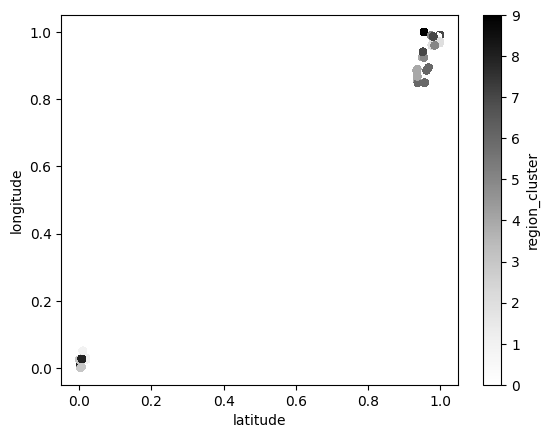

In [4]:
dataset_train.plot(x="latitude", y="longitude", kind="scatter", c="region_cluster")

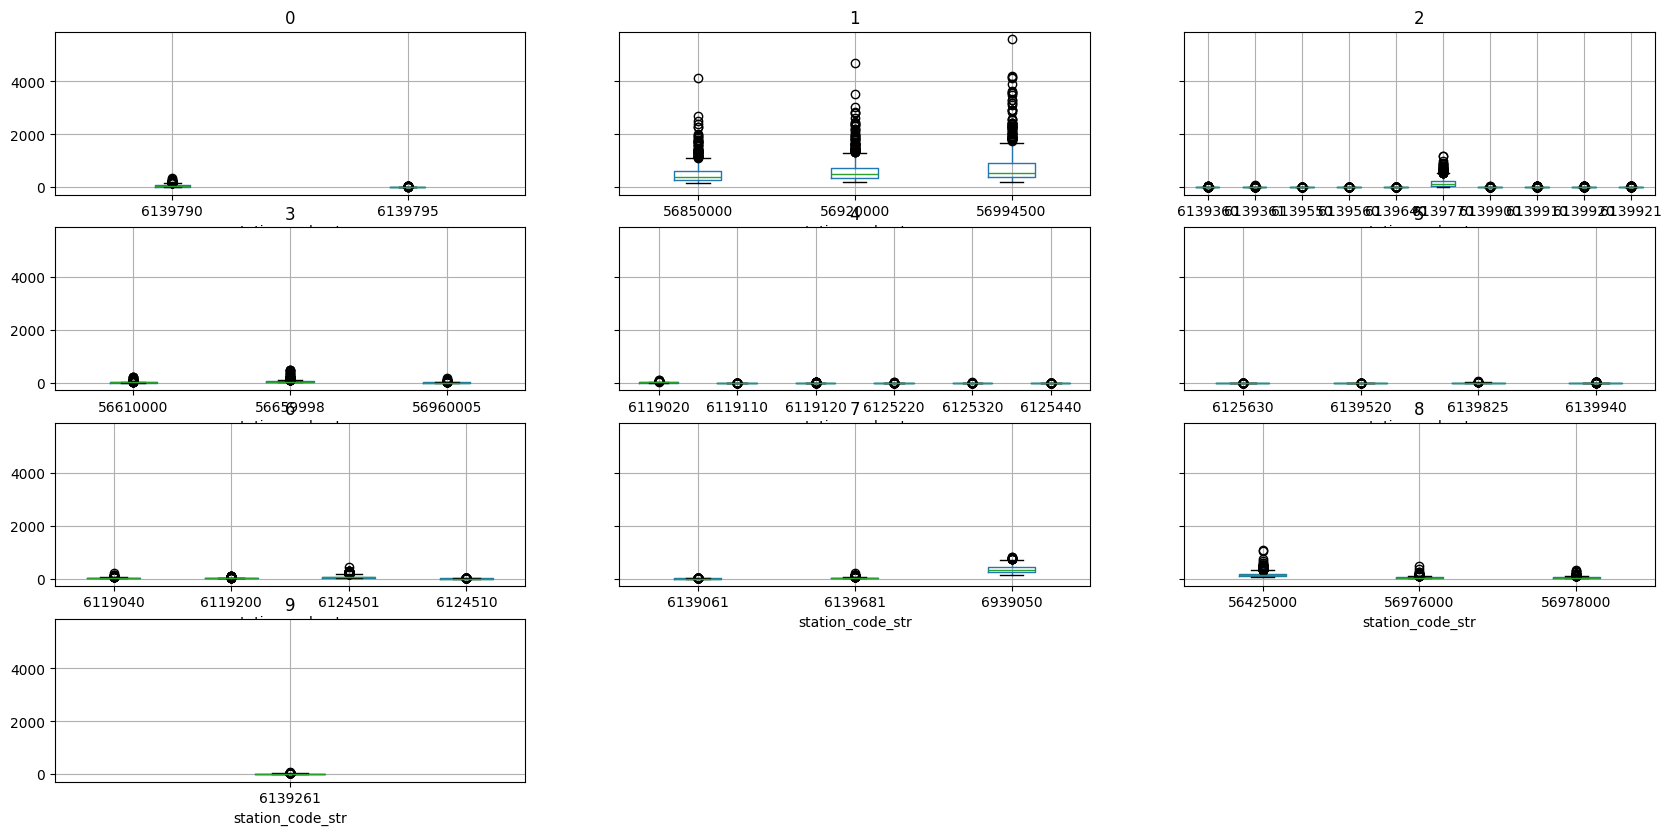

In [5]:
dataset_temp = dataset_train.copy()

import matplotlib.pyplot as plt

dataset_temp["station_code_str"] = dataset_temp["station_code"].astype(str)

dataset_temp.groupby("region_cluster").boxplot(
    column="water_flow_week1", by="station_code_str", figsize=(20, 10)
)

plt.xlabel("Station")
plt.ylabel("Water flow")
plt.title("Water flow distribution per station")
plt.suptitle("")
plt.show()

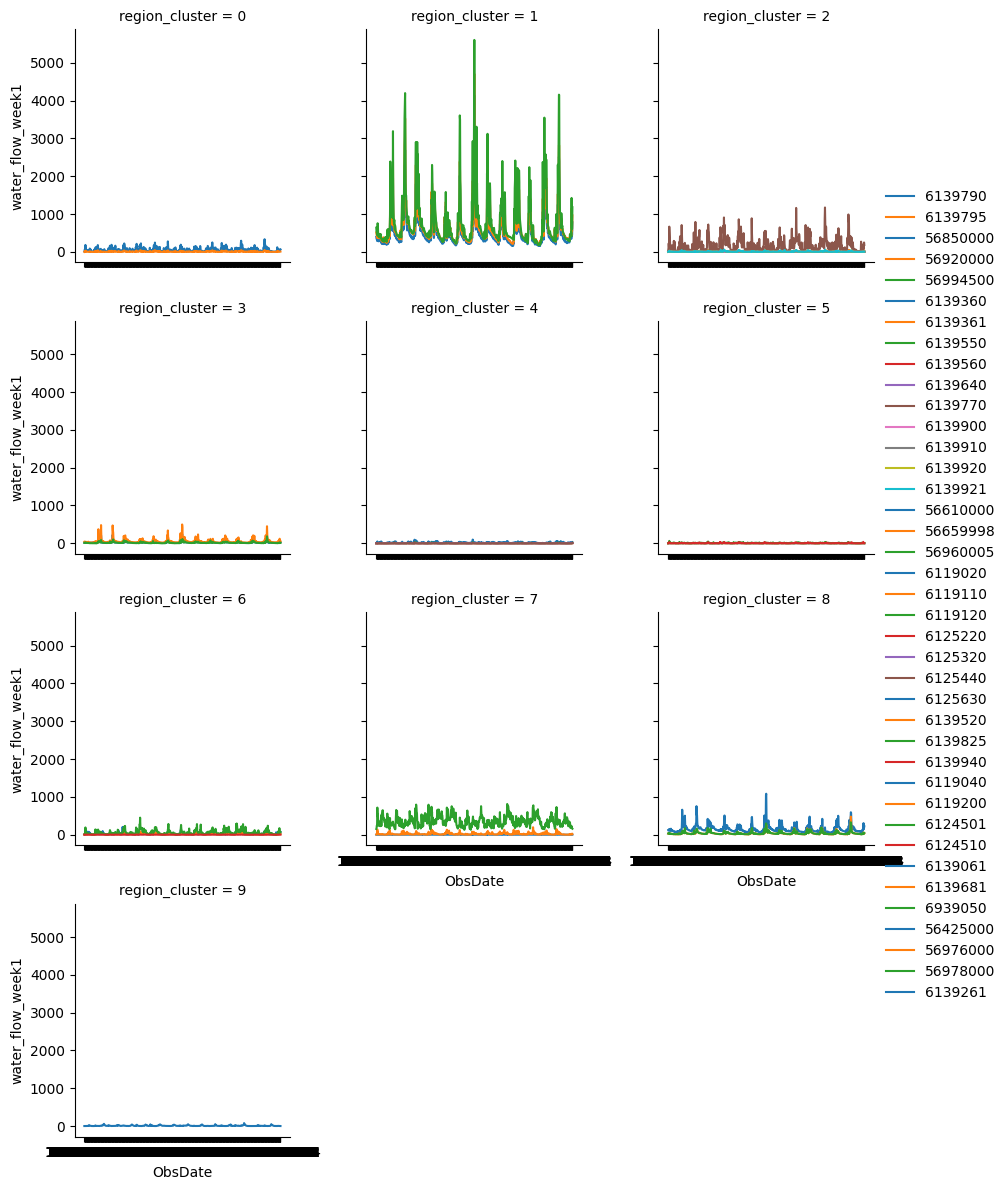

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.FacetGrid(dataset_temp, col="region_cluster", col_wrap=3)

g.map_dataframe(sns.lineplot, x="ObsDate", y="water_flow_week1", hue="station_code_str")

g.add_legend()

plt.show()

Data pre-processing removal of unnecessary columns, setup of the target


In [7]:
X_train = dataset_train.drop(columns=COLUMNS_TO_DROP)
y_train = {}
for i in range(0, NUMBER_OF_WEEK):
    y_train[i] = dataset_train[f"water_flow_week{i+1}"]

### 2. Models training

#### a. LGBM + MAPIE


## Mapie Model Training Overview

- **Configuration:**
  - Sets `ALPHA` (0.1) as the prediction interval level.
  - Defines `TIME_VALIDATION` as a split point for creating a validation set.
  - Configures LightGBM parameters (`LGBM_PARAMS`) for quantile regression.


In [8]:
ALPHA = 0.1
TIME_VALIDATION = "2000-01-01 00:00:00"

LGBM_PARAMS = {
    "max_depth": 15,
    "learning_rate": 0.01,
    "n_estimators": 500,
    "colsample_bytree": 0.7,
    "objective": "quantile",
    "alpha": ALPHA,
}

- **Data Preparation:**

  - Splits `dataset_train` into training and validation subsets using `split_dataset`.
  - Removes unnecessary columns from both the training and validation datasets.
  - Extracts target variables for each week (from `water_flow_week1` to `water_flow_week4`).

- **Model Training:**  
  For each week:
  - Initializes a LightGBM regressor with the specified parameters.
  - Wraps it in a `MapieQuantileRegressor` to estimate prediction intervals.
  - Trains the model on the training data and calibrates it using the validation data.
  - Saves the trained model


In [9]:
if "mapie" in FINAL_MODELS:
    print("Training Mapie")

    train_mapie, val_mapie, val_temporal = split_dataset(
        dataset_train, 0.75, TIME_VALIDATION
    )

    X_train_mapie = train_mapie.drop(columns=COLUMNS_TO_DROP)
    X_train_mapie = X_train_mapie.drop(columns=["station_code"])
    print(len(X_train_mapie.columns))
    y_train_mapie = {}
    for i in range(0, NUMBER_OF_WEEK):
        y_train_mapie[i] = train_mapie[f"water_flow_week{i+1}"]

    X_val = val_mapie.drop(columns=COLUMNS_TO_DROP)
    X_val = X_val.drop(columns=["station_code"])
    y_val = {}
    y_val[0] = val_mapie["water_flow_week1"]
    for i in range(1, NUMBER_OF_WEEK):
        y_val[i] = val_mapie[f"water_flow_week{i+1}"]

    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Initialize and train MapieQuantileRegressor
        regressor = lgb.LGBMRegressor(**LGBM_PARAMS)
        mapie[i] = MapieQuantileRegressor(
            estimator=regressor, method="quantile", cv="split", alpha=ALPHA
        )
        mapie[i].fit(X_train_mapie, y_train_mapie[i], X_calib=X_val, y_calib=y_val[i])

        # save model with date
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")

        model_path = f"{MODEL_DIR}final/mapie_quantile_{time}_week_{i}.pkl"
        joblib.dump(mapie[i], model_path)

#### b. QRF

- **Training:**  
  Initializes a `RandomForestQuantileRegressor` with the following parameters:

  - 100 estimators
  - Maximum depth of 10
  - Minimum of 10 samples per leaf

  These parameters allow for relatively fast training, though they are not optimized for peak performance.

  The model is then fitted using `X_train` and the corresponding weekly target `y_train[i]`.


In [10]:
X_train_qrf = X_train.drop(columns=["station_code"])

if "qrf" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        # Train RandomForestQuantileRegressor
        qrf[i] = RandomForestQuantileRegressor(
            n_estimators=50, max_depth=7, min_samples_leaf=6
        )
        qrf[i].fit(X_train_qrf, y_train[i])

        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        model_path = f"{MODEL_DIR}final/qrf_quantile_{time}_week_{i}.pkl"
        joblib.dump(qrf[i], model_path)

Training week 0
Training week 1
Training week 2
Training week 3


##### b.1 LGBM


In [11]:
X_train_lgbm = X_train.drop(columns=["station_code"])

quantiles = [0.05, 0.5, 0.95]

if "lgbm" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training week {i}")
        lgbm[i] = {}
        # Train LGBMRegressor
        for q in quantiles:
            print(f"Training quantiles {q}")
            lgbm[i][q] = lgb.LGBMRegressor(
                objective="quantile",
                alpha=q,
                n_estimators=100,
                max_depth=5,
                learning_rate=0.1,
            )
            lgbm[i][q].fit(X_train_lgbm, y_train[i])
            time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
            model_path = f"{MODEL_DIR}final/lgbm_quantile_q{q}_{time}_week_{i}.pkl"
            joblib.dump(lgbm[i][q], model_path)

Training week 0
Training quantiles 0.05
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000961 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10017
[LightGBM] [Info] Number of data points in the train set: 28431, number of used features: 57
[LightGBM] [Info] Start training from score 0.144786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

#### c. Explainable Boosting Machine

EBM is an ensemble method that does not natively provide access to its individual members for performing quantile predictions or generating prediction intervals. To overcome this limitation, we manually construct an ensemble.

- **Ensemble Training:**
- For each ensemble member (seed from 0 to `#NUM_ENSEMBLES`):
  - A bootstrap sample is created from `X_train` and `y_train[i]` using sampling with replacement.
  - An `ExplainableBoostingRegressor` is instantiated with fixed parameters (e.g., `max_bins=128`, `learning_rate=0.05`, `interactions=3`, and `random_state=42` to ensure consistent binning) and then trained on the sampled data.
  - The trained model is appended to the list for the current week.
- **Saving the Ensemble:**
- The ensemble (i.e., the list of EBM models for the week) is saved.


In [12]:
if "ebm" in FINAL_MODELS:
    NUM_ENSEMBLES = 10
    ebm_ensembles = {}
    for i in range(NUMBER_OF_WEEK):
        print(f"Training EBM ensemble for week {i}")

        models_i = []
        for seed in range(NUM_ENSEMBLES):
            print(f"Training EBM ensemble {seed} for week {i}")
            # 1. Create your bootstrap sample or subset (if you want bagging)
            sample_indices = np.random.choice(
                len(X_train), size=len(X_train), replace=True
            )
            X_sample = X_train.iloc[sample_indices]
            y_sample = y_train[i][sample_indices]

            # 2. Train an EBM with consistent binning parameters
            ebm_model = ExplainableBoostingRegressor(
                outer_bags=1,
                inner_bags=1,
                max_bins=128,
                learning_rate=0.05,
                interactions=3,
                early_stopping_rounds=100,
                random_state=SEED,
            )
            ebm_model.fit(X_sample, y_sample)

            models_i.append(ebm_model)

        ebm_ensembles[i] = models_i
        time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/ebm_ensemble_{time}_week_{i}.pkl"

        joblib.dump(ebm_ensembles[i], file_path)
        print(f"Saved EBM ensembles to {file_path}")

#### d. Deep Ensemble

The Deep Ensemble is a quantile regression on an ensemble of models. We train one ensemble per week to predict the water flow for that week. The models are trained using the same hyperparameters, except seeds and .

- **Ensemble Training:**
- For each ensemble member (seed from 0 to 4):
  - Create a bootstrap sample of the training data.
  - Train a quantile regression model using the same hyperparameters as the individual models in the ensemble.
- Save the ensemble to a file.


In [675]:
station_codes = X_train["station_code"].unique()
if "deep_ensemble" in FINAL_MODELS:
    NUM_ENSEMBLES = 15
    deep_ensembles = {}

    for i in range(NUMBER_OF_WEEK):
        print(f"Training deep ensemble for week {i}")
        models_i = []

        for seed in range(NUM_ENSEMBLES):
            print(f"Training deep ensemble model {seed} for week {i}")

            selected_station_codes = np.random.choice(
                station_codes, size=len(station_codes) - 3, replace=False
            )
            sample_indices = X_train["station_code"].isin(selected_station_codes)
            X_sample = X_train[sample_indices]
            y_sample = y_train[i][sample_indices]
            tf.random.set_seed(seed * SEED)

            X_sample = X_sample.drop(columns=["station_code"])
            input_shape = (X_sample.shape[1],)
            model = create_deep_model(input_shape)

            model.fit(X_sample, y_sample, epochs=100, batch_size=1500, verbose=0)

            models_i.append(model)

        deep_ensembles[i] = models_i

        time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_path = f"{MODEL_DIR}final/deep_ensemble_{time_str}_week_{i}.pkl"
        joblib.dump(models_i, file_path)
        print(f"Saved deep ensemble for week {i} to {file_path}")

#### e. LSTM


##### Features Normalization and Scaling


In [13]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [14]:
geo_features = ["latitude", "longitude", "catchment", "altitude"]

numerical_features = [
    "precipitations",
    "temperatures",
    "soil_moisture",
    "evaporation",
]

prediction_columns = [
    "water_flow_week1",
    "water_flow_week2",
    "water_flow_week3",
    "water_flow_week4",
]

regional_features = [
    "precipitation_region",
    "temperature_region",
    "soil_moisture_region",
    "evaporation_region",
    "precipitation_zone",
    "temperature_zone",
    "soil_moisture_zone",
    "evaporation_zone",
    "precipitation_sector",
    "temperature_sector",
    "soil_moisture_sector",
    "evaporation_sector",
    "precipitation_sub_sector",
    "temperature_sub_sector",
    "soil_moisture_sub_sector",
    "evaporation_sub_sector",
]

lagged_features = [
    "water_flow_lag_1w",
    "water_flow_lag_2w",
    "precipitations_lag_1w",
    "temperatures_lag_1w",
    "evaporation_lag_1w",
    "precipitation_region_lag_1w",
    "temperature_region_lag_1w",
    "evaporation_region_lag_1w",
    "precipitation_zone_lag_1w",
    "temperature_zone_lag_1w",
    "evaporation_zone_lag_1w",
    "precipitation_sector_lag_1w",
    "temperature_sector_lag_1w",
    "evaporation_sector_lag_1w",
    "precipitation_sub_sector_lag_1w",
    "temperature_sub_sector_lag_1w",
    "evaporation_sub_sector_lag_1w",
]

pca_features = [col for col in dataset_train.columns if "pca" in col]

temp_features = [
    "season_cos",
    "season_sin",
    "month_cos",
    "month_sin",
]

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    RobustScaler,
    FunctionTransformer,
    StandardScaler,
    MinMaxScaler,
)


features_transformer = Pipeline(
    [
        ("scaler_minmax", MinMaxScaler()),
        # ("scaler_standard", StandardScaler()),
    ]
)

log_transformer = FunctionTransformer(
    func=np.log1p, inverse_func=np.expm1, validate=True
)

labels_transformer = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("scaler_minmax", MinMaxScaler()),
    ]
)

dataset_train_lstm = dataset_train.copy(deep=True)

dataset_train_lstm[
    ["evaporation", "region_cluster"] + pca_features + temp_features + lagged_features
] = features_transformer.fit_transform(
    dataset_train_lstm[
        ["evaporation", "region_cluster"]
        + pca_features
        + temp_features
        + lagged_features
    ]
)

# dataset_train_lstm[
#     geo_features + numerical_features + regional_features + lagged_features
# ] = features_transformer.fit_transform(
#     dataset_train_lstm[
#         geo_features + numerical_features + regional_features + lagged_features
#     ]
# )

for prediction_column in prediction_columns:
    dataset_train_lstm[prediction_column] = labels_transformer.fit_transform(
        dataset_train_lstm[[prediction_column]]
    )

dataset_train_lstm = dataset_train_lstm[dataset_train_lstm["station_code"] != 6939050]

/var/folders/3h/5n6s9rcj3sx0gpncsxbq_99m0000gn/T/ipykernel_32040/4251627100.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(dataset_train_lstm.keys(), rotation=90)


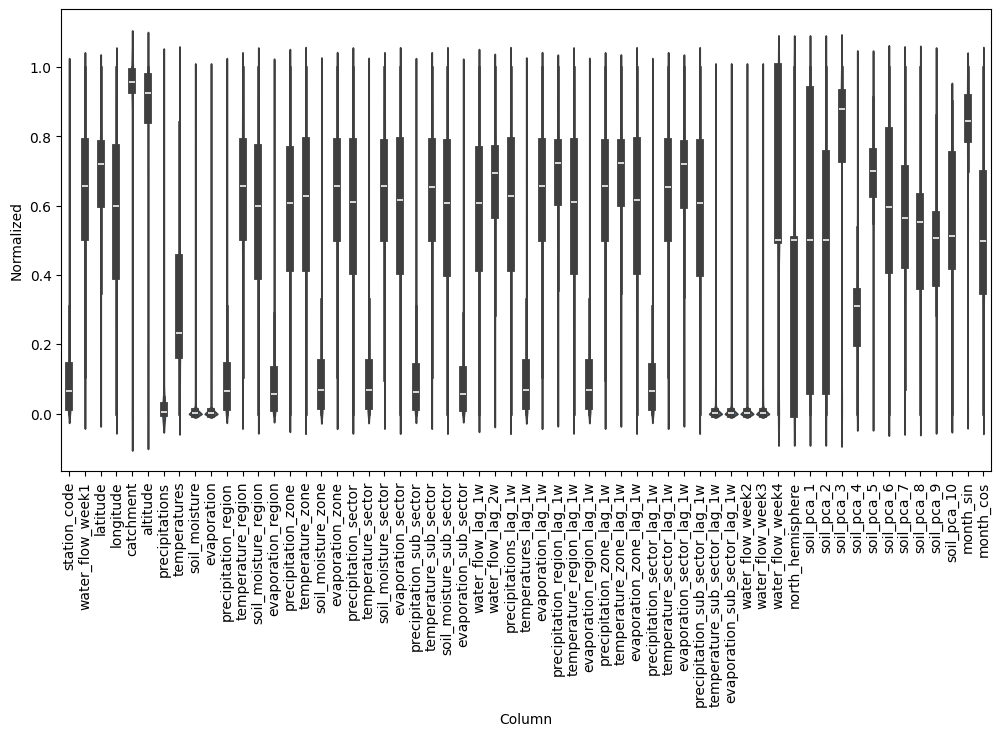

In [16]:
dataset_melt = dataset_train_lstm[
    numerical_features
    + geo_features
    + lagged_features
    + regional_features
    + prediction_columns
    + temp_features
    + pca_features
].melt(var_name="Column", value_name="Normalized")

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

ax = sns.violinplot(x="Column", y="Normalized", data=dataset_melt)
_ = ax.set_xticklabels(dataset_train_lstm.keys(), rotation=90)

In [17]:
def get_y_train(df, number_of_weeks=NUMBER_OF_WEEK):
    y_train = {}
    df_copy = df.copy()
    for i in range(0, number_of_weeks):
        y_train[i] = df[f"water_flow_week{i+1}"]
        df_copy.drop(columns=[f"water_flow_week{i+1}"], inplace=True)
    return df_copy, y_train

In [18]:
dataset_train_brazil = dataset_train_lstm[dataset_train_lstm["north_hemisphere"] == 0]
dataset_train_france = dataset_train_lstm[dataset_train_lstm["north_hemisphere"] == 1]

# Get y_train for each dataset and drop the columns
x_train_global, y_train_global = get_y_train(dataset_train_lstm)
x_train_brazil, y_train_brazil = get_y_train(dataset_train_brazil)
x_train_france, y_train_france = get_y_train(dataset_train_france)

In [406]:
import numpy as np

TIME_STEPS = 12


def create_lstm_sequences(x, target=None, time_steps=TIME_STEPS, drop_remainder=False):
    """Convert dataframe into 3D sequences for LSTM, with optional drop_remainder control"""
    X, y = [], []

    for i in range(len(x)):
        if i + time_steps > len(x):  # Handle sequences that exceed dataset length
            if drop_remainder:
                break  # Stop if drop_remainder=True
            seq = x.iloc[i:].values  # Take remaining values
        else:
            seq = x.iloc[i : i + time_steps].values  # Regular sequence

        X.append(seq)

        if target is not None:
            target_idx = min(i + time_steps, len(target) - 1)  # Avoid index error
            y.append(target.iloc[target_idx])

    # Ensure all sequences have the same shape (padding for shorter ones)
    if not drop_remainder:
        max_length = time_steps
        X = [
            (
                np.pad(seq, ((0, max_length - len(seq)), (0, 0)), mode="constant")
                if len(seq) < max_length
                else seq
            )
            for seq in X
        ]

    return (np.array(X), np.array(y)) if target is not None else np.array(X)

##### Hybrid Loss Function


In [53]:
class HybridLoss(tf.keras.losses.Loss):
    """Custom loss function for quantile regression"""

    def __init__(self, quantile):
        super().__init__()
        self.quantile = quantile

    def call(self, y_true, y_pred):
        """Hybrid loss combining MSE + Quantile Loss"""
        mse = tf.keras.losses.MAE(y_true, y_pred)

        # Apply quantile loss for each quantile
        error = y_true - y_pred
        quantile_loss = tf.reduce_mean(
            tf.maximum(self.quantile * error, (self.quantile - 1) * error)
        )

        return (quantile_loss + mse) / 2

In [324]:
class GaussianLogLikelihoodLoss(tf.keras.losses.Loss):
    def __init__(self, epsilon=1e-6):
        """
        Custom loss for EnsembleLSTM using Gaussian Log Likelihood.

        Parameters:
        - epsilon (float): Small constant to avoid log(0) and division by zero.
        - reduction (tf.keras.losses.Reduction): Reduction method for loss aggregation.
        """
        super().__init__()
        self.epsilon = epsilon  # To prevent log(0)

    def call(self, y_true, y_pred):
        """
        Compute the Gaussian Log Likelihood Loss.

        y_pred shape: (batch_size, n_outputs, 1)
        y_true shape: (batch_size, 1)
        """
        # Expand y_true to match y_pred shape
        y_true = tf.expand_dims(y_true, axis=1)  # Shape: (batch_size, 1, 1)

        # Compute ensemble mean and standard deviation
        mu = tf.reduce_mean(
            y_pred, axis=1, keepdims=True
        )  # Mean prediction (batch_size, 1, 1)
        sigma = (
            tf.math.reduce_std(y_pred, axis=1, keepdims=True) + self.epsilon
        )  # Std deviation

        # Compute Gaussian Log Likelihood Loss
        log_likelihood = 0.5 * tf.math.log(sigma**2) + (
            0.5 * (y_true - mu) ** 2 / (sigma**2)
        )

        # Mean loss across batch
        return tf.reduce_mean(log_likelihood)


class HuberEnsembleLoss(tf.keras.losses.Loss):
    def __init__(self, delta=1.0):
        """
        Custom Huber loss for ensemble models.
        - delta: The threshold where the loss transitions from MSE to MAE.
        """
        super().__init__()
        self.delta = delta

    def call(self, y_true, y_pred):
        """
        Compute the Huber loss over the ensemble predictions.
        """
        y_true_expanded = tf.expand_dims(
            y_true, axis=1
        )  # Match shape: (batch_size, 1, 1)
        y_true_expanded = tf.expand_dims(
            y_true_expanded, axis=1
        )  # Match shape: (batch_size, 1, 1)
        y_true_expanded = tf.tile(
            y_true_expanded, [1, tf.shape(y_pred)[1], 1]
        )  # (batch_size, n_outputs, 1)
        error = y_pred - y_true_expanded

        condition = tf.abs(error) < self.delta
        squared_loss = 0.5 * tf.square(error)
        linear_loss = self.delta * (tf.abs(error) - 0.5 * self.delta)

        loss = tf.where(condition, squared_loss, linear_loss)
        return tf.reduce_mean(loss)  # Mean across batch


class EnsembleLoss(tf.keras.losses.Loss):
    def __init__(self, base_loss="mse"):
        """
        Custom loss for EnsembleLSTM that applies base loss to each output.

        Parameters:
        - base_loss (str): "mse" or "mae" (default: "mse")
        - reduction (tf.keras.losses.Reduction): How to reduce the loss (default: AUTO)
        """
        super().__init__()

        self.loss_name = base_loss

        if base_loss == "mse":
            self.base_loss = tf.keras.losses.MeanSquaredError()
        elif base_loss == "mae":
            self.base_loss = tf.keras.losses.MeanAbsoluteError()
        elif base_loss == "gll":
            self.base_loss = GaussianLogLikelihoodLoss()
        elif base_loss == "huber":
            self.base_loss = HuberEnsembleLoss()
        else:
            raise ValueError("base_loss must be 'mse' or 'mae'")

    def call(self, y_true, y_pred):
        """
        Compute the ensemble loss.
        y_pred shape: (batch_size, n_outputs, 1)
        y_true shape: (batch_size, 1)
        """

        if self.loss_name == "gll" or self.loss_name == "huber":
            return self.base_loss(y_true, y_pred)

        # Expand y_true to match y_pred shape
        y_true = tf.expand_dims(y_true, axis=1)  # Shape: (batch_size, 1, 1)

        # Compute base loss for each model's prediction
        loss_per_model = self.base_loss(
            y_true, y_pred
        )  # Shape: (batch_size, n_outputs)

        # Average the loss across ensemble models
        return tf.reduce_mean(loss_per_model)

##### Quantile LSTM Model


In [325]:
class QuantileLSTM(tf.keras.Model):
    def __init__(self, hidden_units=64, alpha=0.1):
        super(QuantileLSTM, self).__init__()
        self.alpha = alpha
        self.lower_quantile = self.alpha / 2
        self.upper_quantile = 1 - self.alpha / 2

        self.lstm = tf.keras.layers.LSTM(hidden_units, return_sequences=False)
        self.lower_output = tf.keras.layers.Dense(1, activation="linear")
        self.median_output = tf.keras.layers.Dense(1, activation="linear")
        self.upper_output = tf.keras.layers.Dense(1, activation="linear")

        self.compile_model()

    def call(self, inputs):
        x = self.lstm(inputs)

        lower_bound = self.lower_output(x)
        median = self.median_output(x)
        upper_bound = self.upper_output(x)

        return {"lower": lower_bound, "median": median, "upper": upper_bound}

    def compile_model(self, metrics=None):
        self.compile(
            loss={
                "lower": HybridLoss(self.lower_quantile),
                "median": HybridLoss(0.5),
                "upper": HybridLoss(self.upper_quantile),
            },
            optimizer=tf.keras.optimizers.Adam(),
            metrics=metrics,
        )

In [353]:
class EnsembleLSTM(tf.keras.Model):
    def __init__(self, hidden_units=64, n_outputs=3, recurrent_dropout=0.2):
        """
        LSTM model for quantile regression with upper and lower bounds.

        Parameters:
        - hidden_units (int): Number of LSTM units (default=64)
        """
        super(EnsembleLSTM, self).__init__()

        self.predictors = [
            tf.keras.models.Sequential(
                [
                    tf.keras.layers.LSTM(
                        hidden_units,
                        return_sequences=False,
                        recurrent_dropout=recurrent_dropout,
                        kernel_regularizer=tf.keras.regularizers.l2(0.001),
                    ),
                    tf.keras.layers.Dense(1, activation="linear"),
                ]
            )
            for _ in range(n_outputs)
        ]

        self.compile_model()

    def build(self, input_shape):
        """Build the model with input shape"""
        self.input_layer = tf.keras.layers.Input(shape=input_shape)

    def call(self, inputs):
        """Forward pass through the LSTM models"""
        return tf.stack([model(inputs) for model in self.predictors], axis=1)

    def compile_model(self, metrics=None):
        """Compile the model with custom quantile loss"""
        self.compile(
            optimizer="adam",
            loss=EnsembleLoss("mae"),
            metrics=metrics,
        )

In [357]:
from sklearn.cluster import KMeans


class WaterFlowLSTM:
    def __init__(
        self,
        hidden_units=64,
        n_outputs=3,
        recurrent_dropout=0.2,
        time_steps=TIME_STEPS,
        n_clusters=5,
    ):
        self.hidden_units = hidden_units
        self.n_outputs = n_outputs
        self.recurrent_dropout = recurrent_dropout
        self.time_steps = time_steps
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=self.n_clusters, random_state=SEED)
        self.predictors = dict()
        self.key_cols = {"longitude", "latitude"}

    def predict(self, inputs: pd.DataFrame):
        if not isinstance(inputs, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if not bool(self.predictors):
            raise ValueError("Model must be trained first")
        if not self.key_cols.issubset(inputs.columns):
            raise ValueError(f"Input must contain columns {self.key_cols}")

        if not "region_cluster" in inputs.columns:
            inputs["region_cluster"] = self.kmeans.predict(
                inputs[["latitude", "longitude"]]
            )

        predictions = dict()

        for (lon, lat), group in inputs.groupby(
            ["longitude", "latitude"], group_keys=False
        ):
            group = group.sort_values("ObsDate")
            cluster = group["region_cluster"].iloc[0]
            if "station_code" in group.columns:
                group = group.drop(columns=["station_code"])
            if "region_cluster" in group.columns:
                group = group.drop(columns=["region_cluster"])

            X = create_lstm_sequences(
                group, target=None, time_steps=self.time_steps, drop_remainder=True
            )

            if cluster not in self.predictors:
                raise ValueError(f"Cluster {cluster} not trained")
            elif (lon, lat) not in self.predictors[cluster]:
                print(f"Model for station {(lon, lat)} not in cluster {cluster}")
                station_predictions = []
                for model in self.predictors[cluster].values():
                    station_predictions.append(model.predict(X, verbose=0))

                station_predictions = np.stack(station_predictions, axis=-1)
                predictions[(lon, lat)] = np.mean(station_predictions, axis=-1)
            else:
                predictions[(lon, lat)] = self.predictors[cluster][(lon, lat)].predict(
                    X, verbose=0
                )
        return predictions

    def fit(self, inputs: pd.DataFrame, targets, epochs=10):
        if not isinstance(inputs, pd.DataFrame):
            raise ValueError("Input must be a pandas DataFrame")
        if not self.key_cols.issubset(inputs.columns):
            raise ValueError(f"Input must contain columns {self.key_cols}")
        if not "region_cluster" in inputs.columns:
            inputs["region_cluster"] = self.kmeans.fit_predict(
                inputs[["latitude", "longitude"]]
            )

        groups = inputs.groupby(["longitude", "latitude"], group_keys=False)
        n_groups, count = len(groups), 1
        for (lon, lat), group in groups:
            print(f"Training model for station {count}/{n_groups}")
            count += 1
            group = group.sort_values("ObsDate")
            cluster = group["region_cluster"].iloc[0]
            if "station_code" in group.columns:
                group = group.drop(columns=["station_code"])
            if "region_cluster" in group.columns:
                group = group.drop(columns=["region_cluster"])

            X, y = create_lstm_sequences(
                group, target=targets, time_steps=self.time_steps
            )

            if cluster not in self.predictors:
                self.predictors[cluster] = {
                    (lon, lat): EnsembleLSTM(
                        hidden_units=self.hidden_units,
                        n_outputs=self.n_outputs,
                        recurrent_dropout=self.recurrent_dropout,
                    )
                }
            elif (lon, lat) not in self.predictors[cluster]:
                self.predictors[cluster][(lon, lat)] = EnsembleLSTM(
                    hidden_units=self.hidden_units,
                    n_outputs=self.n_outputs,
                    recurrent_dropout=self.recurrent_dropout,
                )

            self.predictors[cluster][(lon, lat)].fit(
                X, y, shuffle=True, epochs=epochs, batch_size=60, verbose=0
            )

##### Training and testing the model on 1 week prediction's


In [ ]:
lstms = {}

train_lstm, val_lstm, val_temporal_lstm = split_dataset(
    dataset_train_lstm, 0.75, TIME_VALIDATION
)

train_lstm, y_train_lstm = get_y_train(train_lstm)

for i in range(1):
    print(f"Training week {i}")
    # Train LSTM model
    lstms[i] = WaterFlowLSTM()

    lstms[i].fit(train_lstm, y_train_lstm, epochs=10)

In [363]:
lstm_predictions = lstms[0].predict(val_temporal_lstm.drop(columns=prediction_columns))

184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [ ]:
import matplotlib.pyplot as plt

for key in lstm_predictions.keys():
    medians = np.median(lstm_predictions[key], axis=1)
    lower_bound = np.quantile(lstm_predictions[key], ALPHA / 2, axis=1)
    upper_bound = np.quantile(lstm_predictions[key], 1 - ALPHA / 2, axis=1)

    current_station = val_temporal_lstm.loc[
        (val_temporal_lstm["latitude"] == key[1])
        & (val_temporal_lstm["longitude"] == key[0])
    ]
    plt.figure(figsize=(12, 6))
    plt.plot(medians, label="Predictions")
    plt.plot(lower_bound, label="Lower bound")
    plt.plot(upper_bound, label="Upper bound")
    plt.plot(current_station["water_flow_week1"], label="True values")
    plt.title(f"Predictions for station {current_station["station_code"].iloc[0]}")
    plt.xticks(rotation=45)

    plt.legend()
    plt.show()

In [407]:
train_lstm, val_lstm, val_temporal_lstm = split_dataset(
    dataset_train_lstm, 0.75, TIME_VALIDATION
)

In [408]:
train_lstm, y_train_lstm = get_y_train(train_lstm)
val_lstm, y_val_lstm = get_y_train(val_lstm)
val_temporal_lstm = get_y_train(val_temporal_lstm)

<Axes: xlabel='ObsDate'>

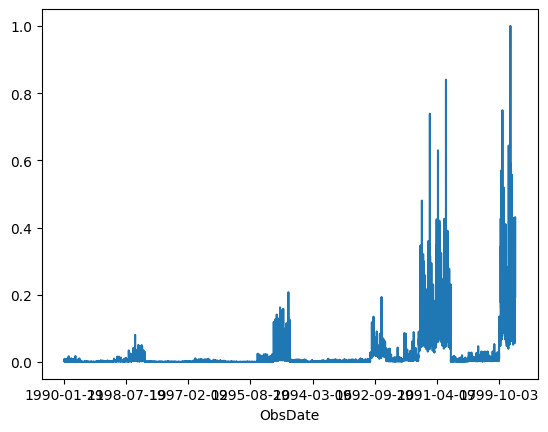

In [415]:
y_train_lstm[0].plot()

In [409]:
ensemble_lstm = EnsembleLSTM()

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=1, restore_best_weights=True
    )
]

In [410]:
x_lstm, y_lstm = create_lstm_sequences(
    train_lstm.drop(columns=["station_code"]), target=y_train_lstm[0]
)

x_test_lstm, y_test_lstm = create_lstm_sequences(
    val_lstm.drop(columns=["station_code"]), target=y_val_lstm[0]
)

ensemble_lstm.fit(
    x_lstm,
    y_lstm,
    validation_data=(
        x_test_lstm,
        y_test_lstm,
    ),
    epochs=30,
    batch_size=120,
    callbacks=callbacks,
)

Epoch 1/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.3068 - val_loss: 0.1666
Epoch 2/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1514 - val_loss: 0.1257
Epoch 3/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.1206 - val_loss: 0.1008
Epoch 4/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0963 - val_loss: 0.0775
Epoch 5/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0806 - val_loss: 0.0713
Epoch 6/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0705 - val_loss: 0.0615
Epoch 7/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0647 - val_loss: 0.0558
Epoch 8/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0574 - val_loss: 0.0480
Epoch 9/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0489 - val_loss: 0.0467
Epoch 10/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0449 - val_loss: 0.0395
Epoch 11/30
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0422 - val_loss: 0.0384
Epoch 12/30
122/122 ━━━━━━━━━━━━━━━━━━━━

In [411]:
predictions = ensemble_lstm.predict(x_test_lstm)

66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


<Axes: >

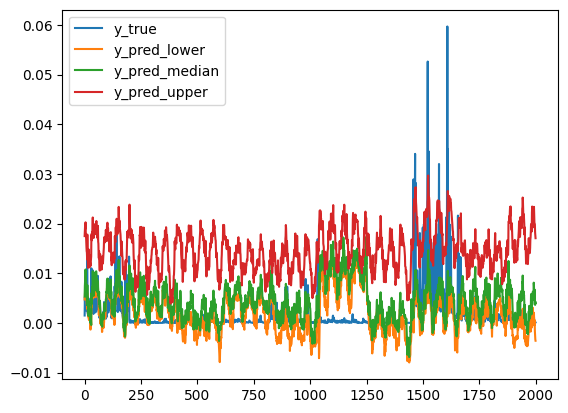

In [412]:
predictions_median = np.median(predictions, axis=1).flatten()
predictions_lower = np.quantile(predictions, 0.05, axis=1).flatten()
predictions_upper = np.quantile(predictions, 0.95, axis=1).flatten()

results = pd.DataFrame(
    {
        "y_true": y_test_lstm,
        "y_pred_lower": predictions_lower,
        "y_pred_median": predictions_median,
        "y_pred_upper": predictions_upper,
    }
)

results[0:2000].plot()

##### Training and testing the model on 4 weeks predictions


In [1688]:
week_lstms = {}

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=1, restore_best_weights=True
    ),
]

if "quant_lstm" in FINAL_MODELS:
    for i in range(NUMBER_OF_WEEK):
        print(f"Training LSTM for week {i}")
        X, y = create_lstm_sequences(x_train_global, y_train_global[i])
        X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(
            X, y, test_size=0.2, shuffle=False
        )

        quantile_lstm = EnsembleLSTM(
            n_outputs=5,
        )
        quantile_lstm.fit(
            X_train_lstm,
            y_train_lstm,
            validation_data=(
                X_test_lstm,
                y_test_lstm,
            ),
            epochs=10,
            batch_size=120,
            callbacks=callbacks,
            verbose=0,
        )

        week_lstms[i] = quantile_lstm

Training LSTM for week 0
Training LSTM for week 1
Training LSTM for week 2
Training LSTM for week 3


#### f. XGBoost


In [49]:
COLUMNS_TO_DROP_FOR_XGB = [
    "north_hemisphere",
]

train_xgboost, val_xgboost, val_temporal_xgboost = split_dataset(
    dataset_train.drop(columns=COLUMNS_TO_DROP_FOR_XGB), 0.75, TIME_VALIDATION
)

In [50]:
x_train_xgboost, y_train_xgboost = get_y_train(train_xgboost)
x_val_xgboost, y_val_xgboost = get_y_train(val_xgboost)
x_eval_xgboost, y_eval_xgboost = get_y_train(val_temporal_xgboost)

##### Tuning XGBoost Hyperparameters


In [21]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import make_scorer


# Define a custom scorer for quantile regression
def quantile_loss(y_true, y_pred, quantile=0.5):
    return mean_pinball_loss(y_true, y_pred, alpha=quantile)


quantile_scorer = make_scorer(mean_pinball_loss, greater_is_better=False, alpha=0.5)

xgb_search_params = {
    "n_estimators": [500, 1000, 2000, 4000],
    "max_depth": [7, 9, 11, 13],
    "learning_rate": [0.01, 0.05, 0.1],
    "colsample_bytree": [0.4, 0.7, 0.9],
}

quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

q_best_params = {}

for q in quantiles:
    print(f"Searching for quantile {q}")
    xgb_model = XGBRegressor(objective="reg:quantileerror", quantile_alpha=q)
    search = RandomizedSearchCV(
        xgb_model,
        xgb_search_params,
        cv=4,
        n_iter=60,
        scoring=quantile_scorer,
        n_jobs=-1,
        verbose=1,
    )
    search.fit(
        x_train_xgboost.drop(columns=["station_code"]),
        y_train_xgboost[0],
    )

    q_best_params[q] = search.best_params_

Searching for quantile 0.05


NameError: name 'XGBRegressor' is not defined

In [31]:
import numpy as np
from xgboost import DMatrix, train
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


class XGBQuantileRegressor(BaseEstimator, RegressorMixin):
    """
    Custom XGBoost model trained on log(y) to ensure positive predictions.
    """

    def __init__(
        self,
        quantile=0.5,
        n_estimators=500,
        learning_rate=0.1,
        max_depth=3,
        objective="reg:squaredlogerror",
        gamma=0,
        min_child_weight=1,
        subsample=1,
        colsample_bytree=1,
    ):
        self.quantile = quantile
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.objective = objective
        self.gamma = gamma
        self.min_child_weight = min_child_weight
        self.subsample = subsample
        self.colsample_bytree = colsample_bytree
        self.model_ = None

    def _quantile_gradient(self, y_true, y_pred):
        """Gradient of quantile loss."""
        residual = y_true - y_pred
        return np.where(residual > 0, -self.quantile, -(self.quantile - 1))

    def _quantile_hessian(self, y_true):
        """Hessian (second derivative) is constant for quantile loss."""
        return np.ones_like(y_true)

    def fit(self, X, y, eval_set=None):
        """Train model on log-transformed target."""
        feature_names = X.columns.tolist()

        X, y = check_X_y(X, y)

        if np.any(y <= 0):
            raise ValueError(
                "All target values must be positive for log transformation."
            )

        y_log = np.log(y)  # Apply log transformation

        dtrain = DMatrix(X, label=y_log, feature_names=feature_names)

        params = {
            "objective": self.objective,
            "eta": self.learning_rate,
            "max_depth": self.max_depth,
            "gamma": self.gamma,
            "min_child_weight": self.min_child_weight,
            "subsample": self.subsample,
            "colsample_bytree": self.colsample_bytree,
        }

        if eval_set is not None:
            eval_set = [
                (DMatrix(X_eval, label=np.log(y_eval)), "validation")
                for X_eval, y_eval in eval_set
            ]

        self.model_ = train(
            params,
            dtrain,
            evals=eval_set,
            num_boost_round=self.n_estimators,
            obj=self._custom_loss,
            verbose_eval=False,
        )
        return self

    def _custom_loss(self, y_pred, dtrain):
        """Custom loss function."""
        y_true = dtrain.get_label()
        grad = self._quantile_gradient(y_true, y_pred)
        hess = self._quantile_hessian(y_true)
        return grad, hess

    def predict(self, X):
        """Predict and exponentiate to ensure positive values."""
        check_is_fitted(self, "model_")
        X = check_array(X)

        dtest = DMatrix(X)
        y_pred_log = self.model_.predict(dtest, validate_features=False)
        return np.exp(y_pred_log)  # Convert back to original scale

In [32]:
def nll_coverage_scorer(estimator, X, y, ALPHA=0.1):
    quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

    models = {
        q: XGBQuantileRegressor(
            quantile=q,
            n_estimators=estimator.n_estimators,
            learning_rate=estimator.learning_rate,
            max_depth=estimator.max_depth,
        )
        for q in quantiles
    }

    for q in quantiles:
        models[q].fit(X.drop(columns=["station_code"]), y)

    y_pred_lower = models[ALPHA / 2].predict(X.drop(columns=["station_code"]))
    y_pred_median = models[0.5].predict(X.drop(columns=["station_code"]))
    y_pred_upper = models[1 - ALPHA / 2].predict(X.drop(columns=["station_code"]))

    y_pred_intervals = np.stack([y_pred_lower, y_pred_upper], axis=1)

    station_code_subset = X["station_code"].values

    station_stats = get_station_stats(y, station_code_subset)
    y = standardize_values(y, station_code_subset, station_stats)
    y_pred_median = standardize_values(
        y_pred_median, station_code_subset, station_stats
    )

    y_pred_lower, y_pred_upper = standardize_prediction_intervals(
        y_pred_intervals, station_code_subset, station_stats
    )

    sigma = (y_pred_upper - y_pred_lower) / 3.29
    sigma = np.maximum(sigma, 1e-6)  # Avoid division by zero

    nll = np.mean(np.log(sigma) + np.abs(y - y_pred_median) / (2 * sigma))
    coverage = np.mean((y >= y_pred_lower) & (y <= y_pred_upper))

    return coverage - nll

In [41]:
from sklearn.model_selection import RandomizedSearchCV

xgb_search_params = {
    "n_estimators": [200, 300, 500, 1000],
    "max_depth": [2, 3, 4, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "objective": ["reg:squaredlogerror", "reg:squarederror", "reg:pseudohubererror"],
    "gamma": [0, 0.1, 0.5, 1, 5],
    "min_child_weight": [5, 7, 10],
    "subsample": [0.5, 0.7, 1],
}


random_search = RandomizedSearchCV(
    XGBQuantileRegressor(quantile=0.5),
    xgb_search_params,
    n_iter=60,
    cv=4,
    scoring=nll_coverage_scorer,
    n_jobs=-1,
    verbose=2,
)

random_search.fit(x_train_xgboost, y_train_xgboost[0])

Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV] END gamma=5, learning_rate=0.01, max_depth=2, min_child_weight=7, n_estimators=500, objective=reg:squarederror, subsample=1; total time=   2.7s
[CV] END gamma=5, learning_rate=0.01, max_depth=2, min_child_weight=7, n_estimators=500, objective=reg:squarederror, subsample=1; total time=   3.1s
[CV] END gamma=5, learning_rate=0.01, max_depth=2, min_child_weight=7, n_estimators=500, objective=reg:squarederror, subsample=1; total time=   3.2s
[CV] END gamma=5, learning_rate=0.01, max_depth=2, min_child_weight=7, n_estimators=500, objective=reg:squarederror, subsample=1; total time=   3.2s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, objective=reg:pseudohubererror, subsample=1; total time=   1.8s
[CV] END gamma=0, learning_rate=0.05, max_depth=3, min_child_weight=7, n_estimators=200, objective=reg:pseudohubererror, subsample=1; total time=   1.5s
[CV] END gamma=0, learning_rate=0.05

RandomizedSearchCV(cv=4, estimator=XGBQuantileRegressor(), n_iter=60, n_jobs=-1,
                   param_distributions={'gamma': [0, 0.1, 0.5, 1, 5],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [2, 3, 4, 7],
                                        'min_child_weight': [5, 7, 10],
                                        'n_estimators': [200, 300, 500, 1000],
                                        'objective': ['reg:squaredlogerror',
                                                      'reg:squarederror',
                                                      'reg:pseudohubererror'],
                                        'subsample': [0.5, 0.7, 1]},
                   scoring=<function nll_coverage_scorer at 0x2b114ade0>,
                   verbose=2)

In [42]:
random_search.best_params_

{'subsample': 1,
 'objective': 'reg:pseudohubererror',
 'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.1,
 'gamma': 1}

In [48]:
quantiles = [ALPHA / 2, 0.5, 1 - ALPHA / 2]

best_params = {"n_estimators": 300, "max_depth": 3, "learning_rate": 0.1}

xgb_models = []

for i in range(NUMBER_OF_WEEK):
    xgb_models.append({})
    for q in quantiles:
        xgb_models[i][q] = XGBQuantileRegressor(
            quantile=q, **random_search.best_params_
        )

        xgb_models[i][q].fit(
            x_train_xgboost.drop(columns=["station_code"]),
            y_train_xgboost[i],
            eval_set=[
                (
                    x_val_xgboost.drop(columns=["station_code"]),
                    y_val_xgboost[i],
                ),
            ],
        )

    time_str = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
    file_path = f"{MODEL_DIR}final/xgb_{time_str}_week_{i}.pkl"
    joblib.dump(xgb_models[i], file_path)
    print(f"Saved xgb for week {i} to {file_path}")

Saved xgb for week 0 to ../../../models/full_pca/final/xgb_2025-03-18_23-50-32_week_0.pkl
Saved xgb for week 1 to ../../../models/full_pca/final/xgb_2025-03-18_23-50-34_week_1.pkl
Saved xgb for week 2 to ../../../models/full_pca/final/xgb_2025-03-18_23-50-35_week_2.pkl
Saved xgb for week 3 to ../../../models/full_pca/final/xgb_2025-03-18_23-50-37_week_3.pkl


/Users/az-r-ow/Developer/WaterScarcity.Hackathon/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


[]

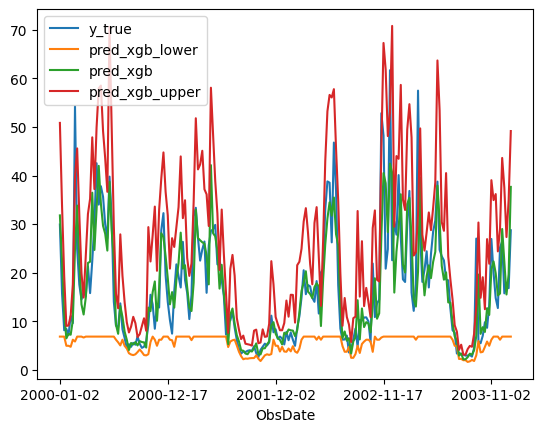

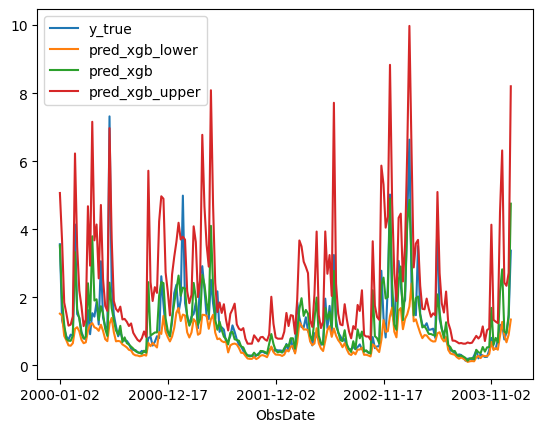

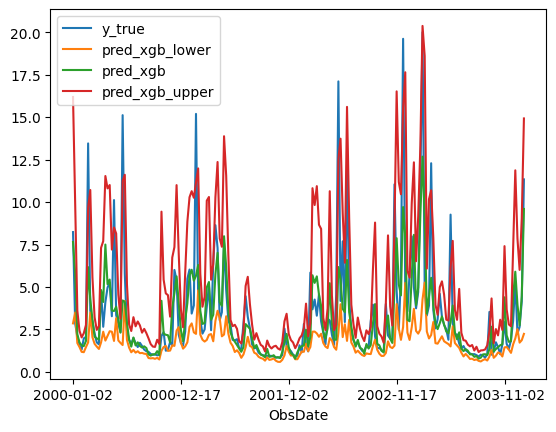

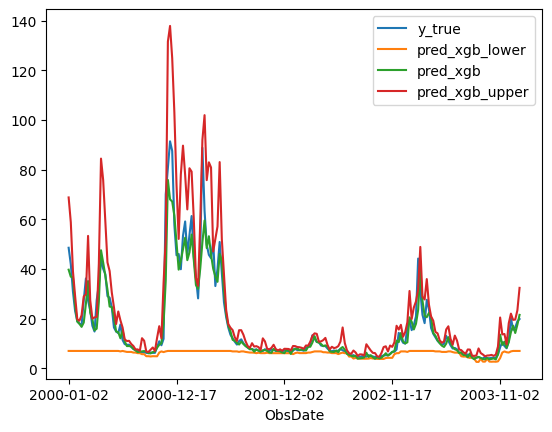

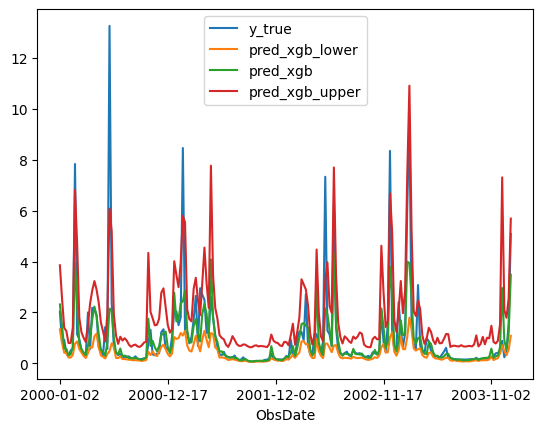

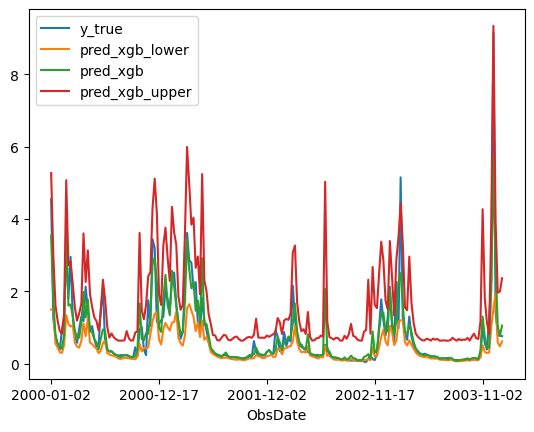

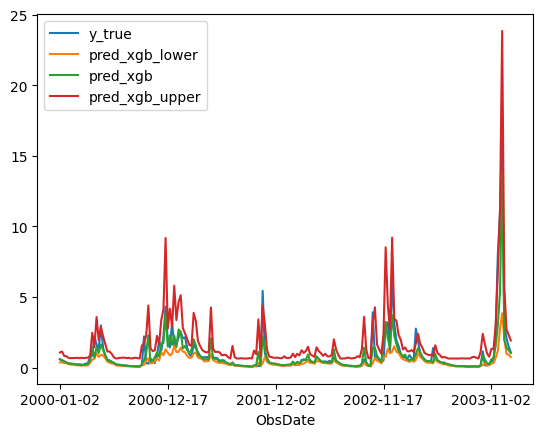

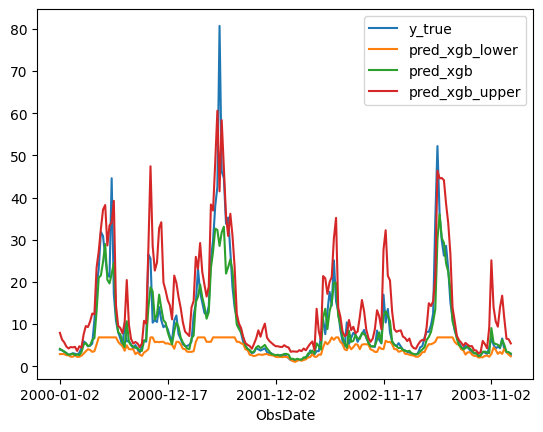

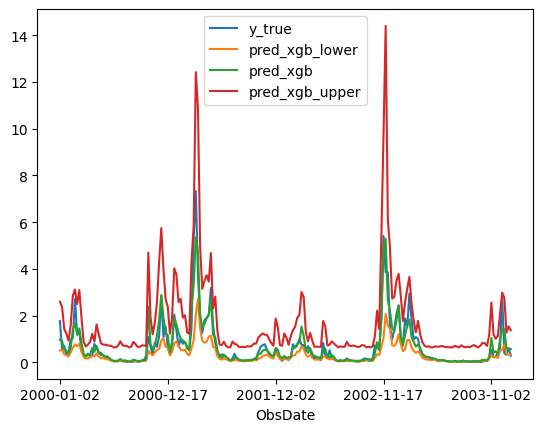

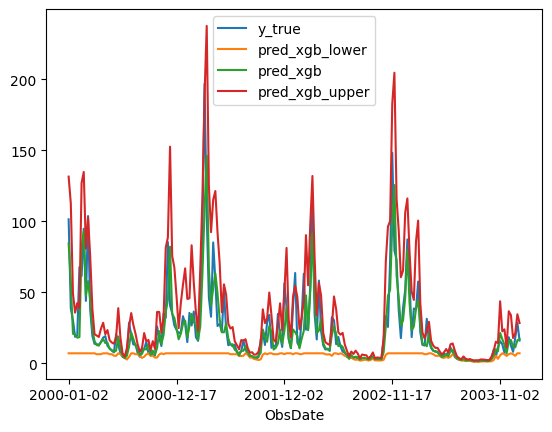

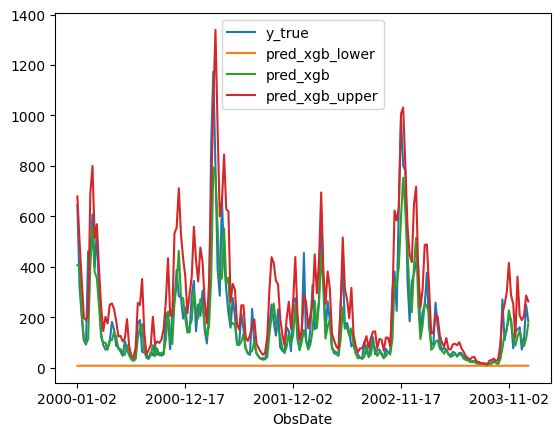

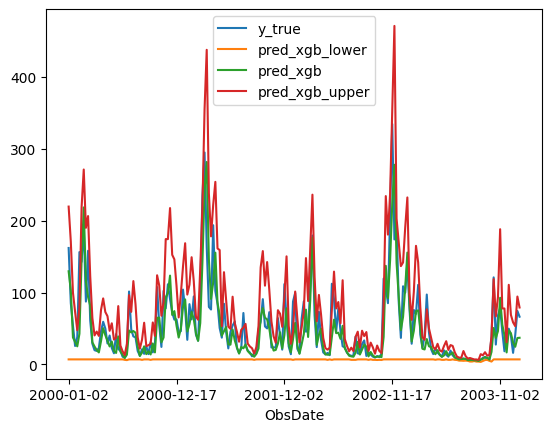

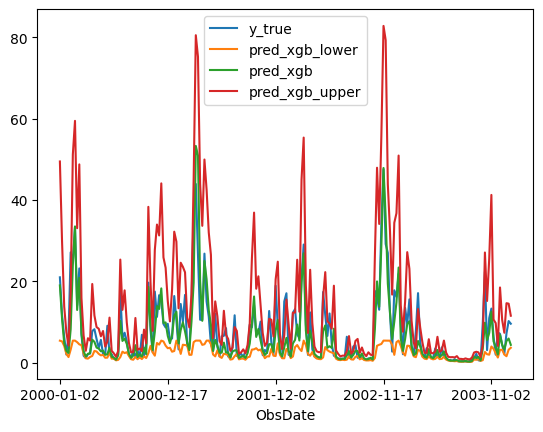

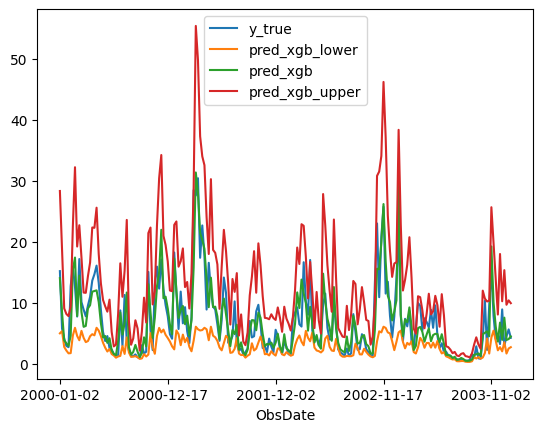

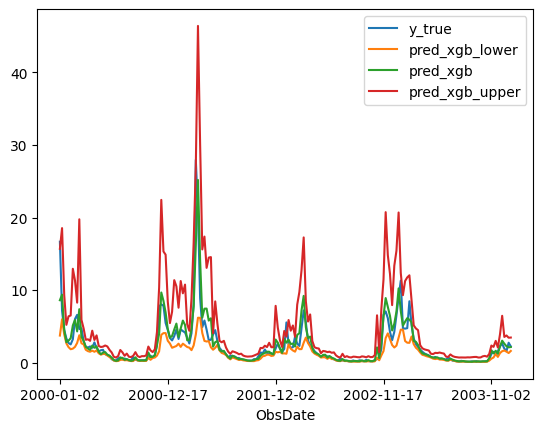

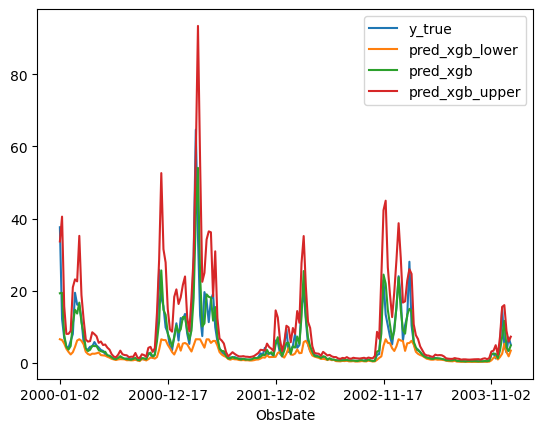

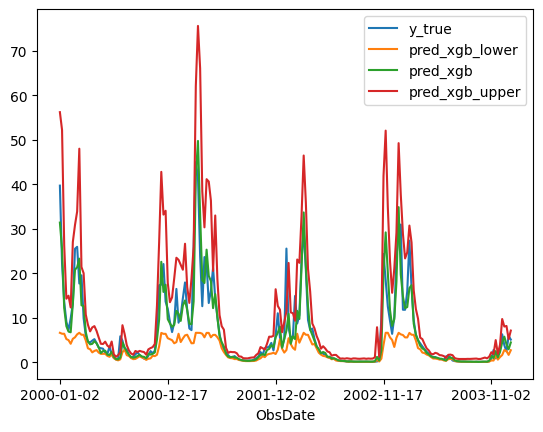

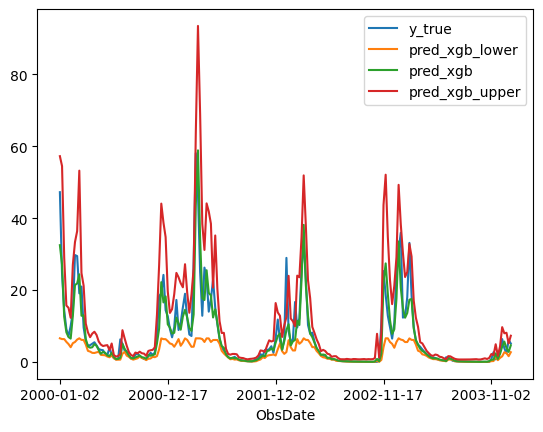

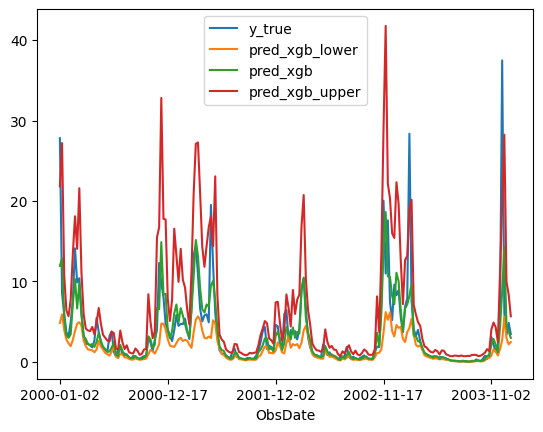

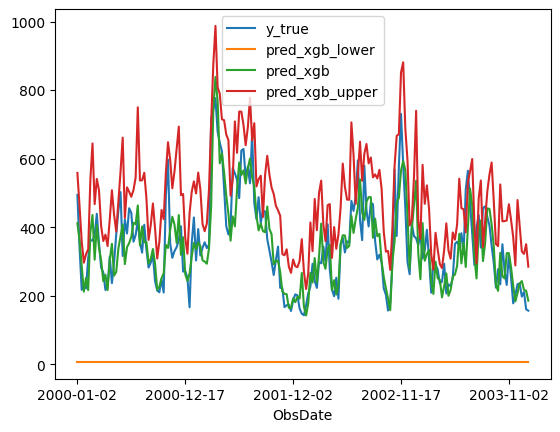

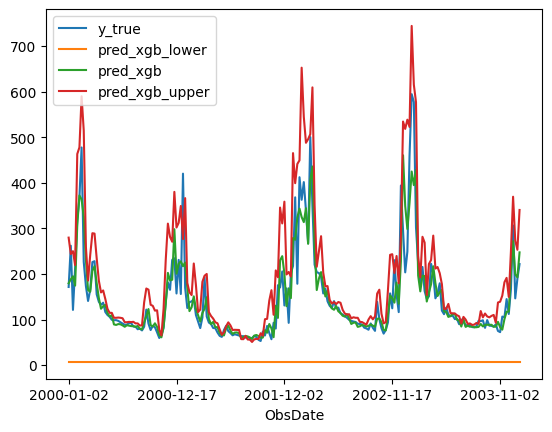

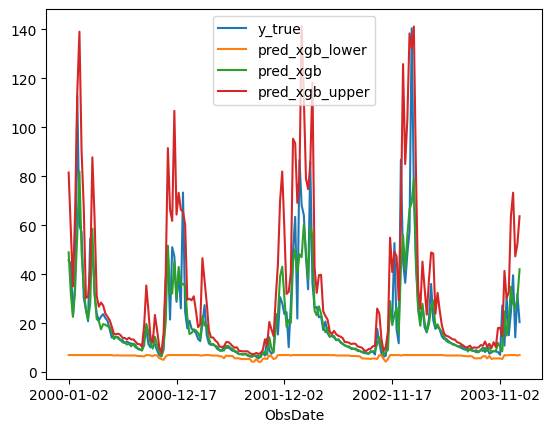

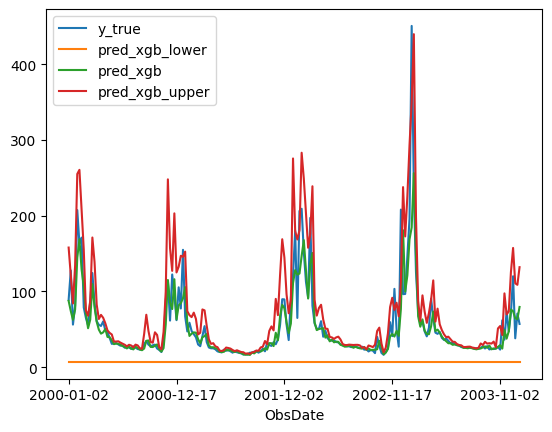

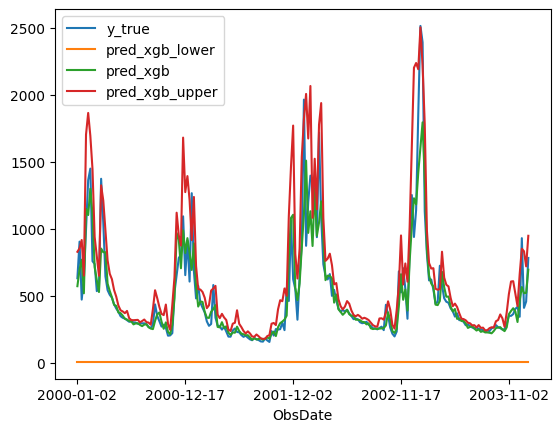

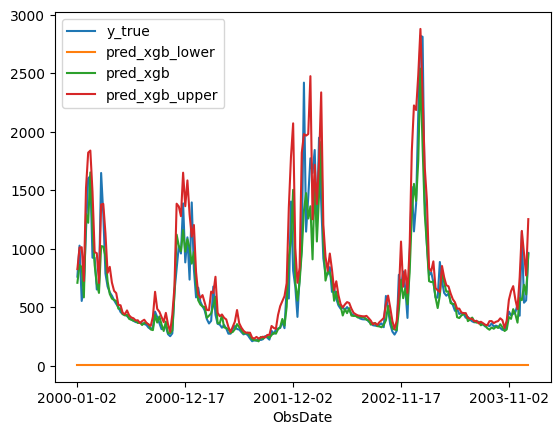

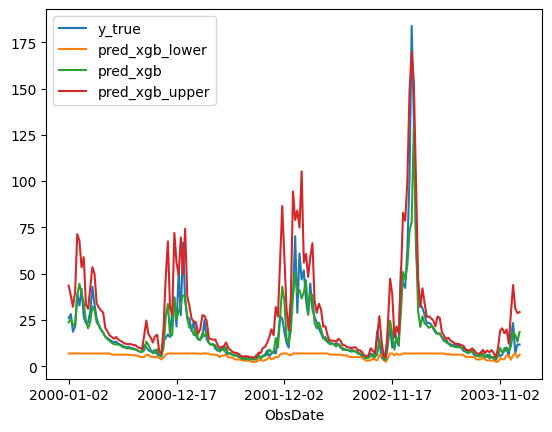

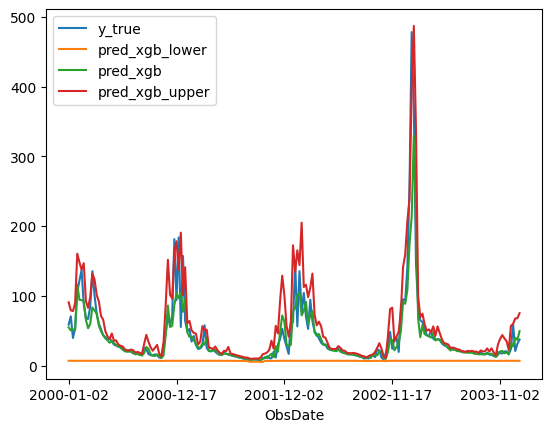

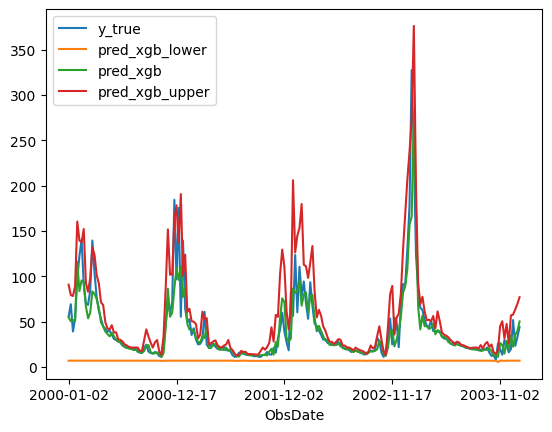

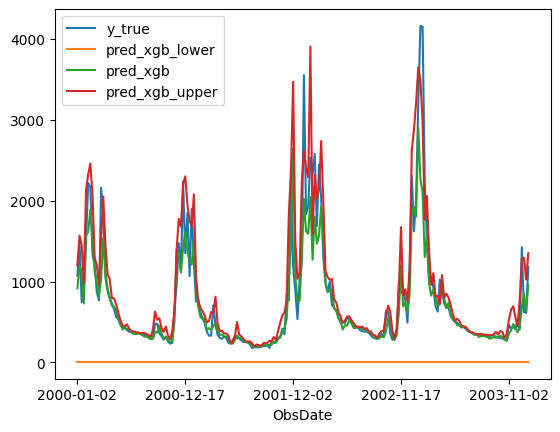

In [44]:
temp_dataset = pd.DataFrame(
    {
        "station_code": x_eval_xgboost["station_code"],
        "y_true": y_eval_xgboost[0],
        "pred_xgb_lower": xgb_models[0][0.05].predict(
            x_eval_xgboost.drop(columns=["station_code"])
        ),
        "pred_xgb": xgb_models[0][0.5].predict(
            x_eval_xgboost.drop(columns=["station_code"])
        ),
        "pred_xgb_upper": xgb_models[0][0.95].predict(
            x_eval_xgboost.drop(columns=["station_code"])
        ),
    }
)

temp_dataset.groupby("station_code")[
    ["y_true"] + [col for col in temp_dataset.columns if "pred_xgb" in col]
].plot(legend=True)

plt.plot()

### 3. Performance Evaluation on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)


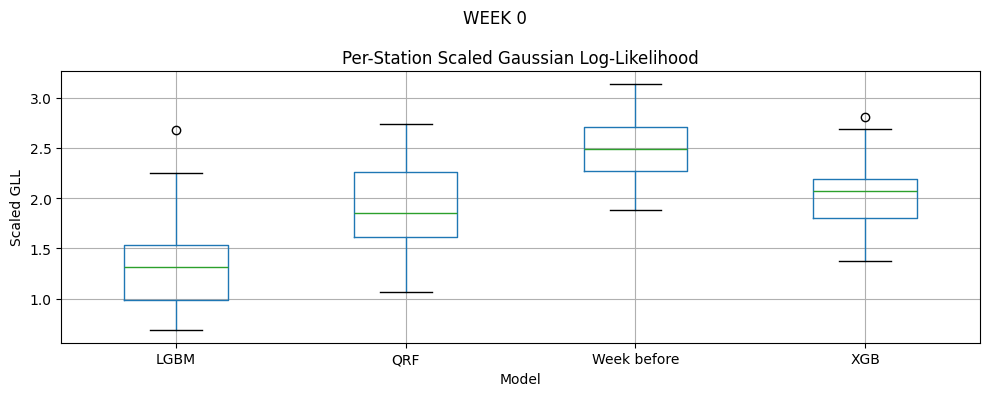

/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/m

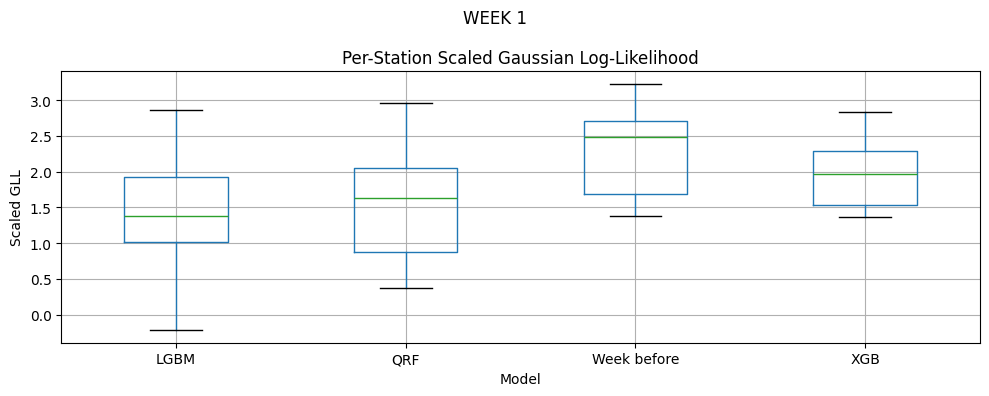

/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/m

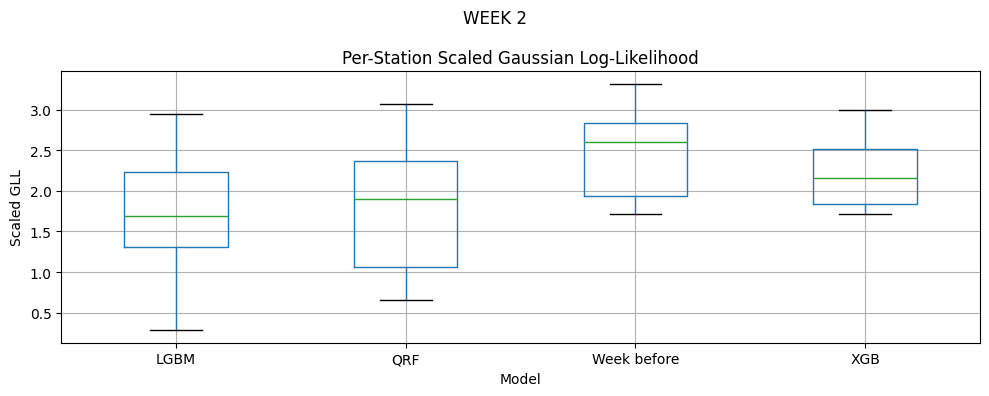

/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/model.py:195: RuntimeWarning: invalid value encountered in log
  np.log(sigma_s) + abs((y_true_s - y_pred_s)) / abs(2 * sigma_s)
/Users/az-r-ow/Developer/WaterScarcity.Hackathon/src/utils/m

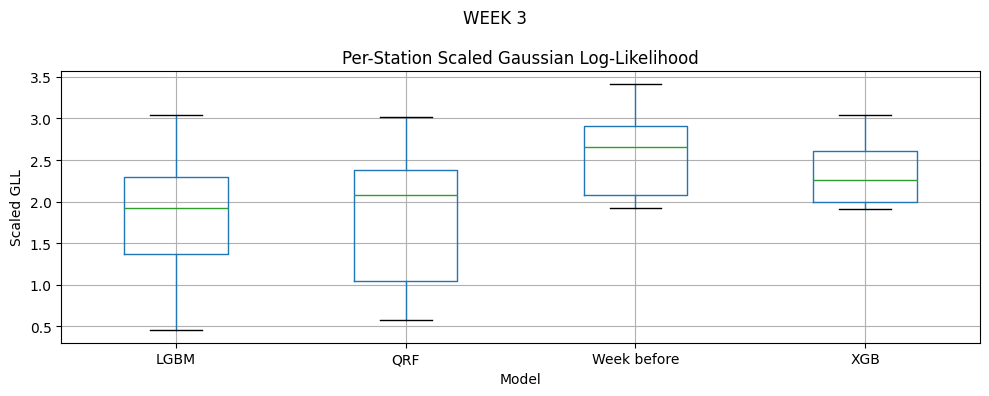

In [45]:
y_train_stations = dataset_train["station_code"].values

X_train_eval = X_train.drop(columns=["station_code"])
for i in range(NUMBER_OF_WEEK):
    predictions = []
    baseline_day_before = dataset_train["water_flow_lag_1w"]
    predictions.append(
        {
            "model": "Week before",
            "prediction": baseline_day_before,
            "dataset": "train",
            "stations": y_train_stations,
            "prediction_interval": None,
        }
    )
    if "mapie" in FINAL_MODELS:
        y_pred_mapie, y_pis_mapie = mapie[i].predict(X_train_eval)
        predictions.append(
            {
                "model": "LGBM+MAPIE",
                "prediction": y_pred_mapie,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_mapie,
            }
        )
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])
        predictions.append(
            {
                "model": "QRF",
                "prediction": y_pred_qrf,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_qrf,
            }
        )
    if "xgb" in FINAL_MODELS:
        X_train_eval_xgb = X_train_eval.drop(columns=["north_hemisphere"])
        y_pred_xgb = xgb_models[i][0.5].predict(X_train_eval_xgb)
        y_interval_xgb = np.stack(
            [
                xgb_models[i][0.05].predict(X_train_eval_xgb),
                xgb_models[i][0.95].predict(X_train_eval_xgb),
            ],
            axis=1,
        )

        predictions.append(
            {
                "model": "XGB",
                "prediction": y_pred_xgb,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": None,
            }
        )
    if "lgbm" in FINAL_MODELS:
        y_pred_lgbm = lgbm[i][0.5].predict(X_train_eval)
        y_pis_lgbm = np.stack(
            [lgbm[i][0.05].predict(X_train_eval), lgbm[i][0.95].predict(X_train_eval)],
            axis=1,
        )
        predictions.append(
            {
                "model": "LGBM",
                "prediction": y_pred_lgbm,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": y_pis_lgbm,
            }
        )
    if "ebm" in FINAL_MODELS:
        y_pred_ebm = []
        for model in ebm_ensembles[i]:
            y_pred_ebm.append(model.predict(X_train_eval))
        # list to array
        y_pred_ebm = np.array(y_pred_ebm)
        intervals = np.percentile(y_pred_ebm, [0, 100], axis=0)
        intervals = intervals[:, :].T
        y_pred_ebm = np.mean(y_pred_ebm, axis=0)
        predictions.append(
            {
                "model": "EBM",
                "prediction": y_pred_ebm,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": intervals,
            }
        )
    if "deep_ensemble" in FINAL_MODELS:
        y_pred_deep = []
        for model in deep_ensembles[i]:
            y_pred_deep.append(model.predict(X_train_eval))
        intervals = np.percentile(y_pred_deep, [0, 100], axis=0)
        intervals = intervals[:, :, 0].T
        y_pred_deep = np.mean(y_pred_deep, axis=0)
        predictions.append(
            {
                "model": "Deep Ensemble",
                "prediction": y_pred_deep[:, 0],
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": intervals,
            }
        )

    if "quant_lstm" in FINAL_MODELS:
        y_pred_quant_lstm = []
        scaled_X_train_eval = X_train_eval.copy()
        scaled_X_train_eval[
            geo_features + numerical_features + regional_features + lagged_features
        ] = features_transformer.transform(
            X_train_eval[
                geo_features + numerical_features + regional_features + lagged_features
            ]
        )
        scaled_X_train_eval = create_lstm_sequences(scaled_X_train_eval)
        week_pred = week_lstms[i].predict(scaled_X_train_eval)
        week_pred_median = np.median(week_pred, axis=1)
        week_pred_lower = np.quantile(week_pred, 0.05, axis=1)
        week_pred_upper = np.quantile(week_pred, 0.95, axis=1)

        y_pred_quant_lstm = labels_transformer.inverse_transform(
            week_pred_median
        ).flatten()
        y_lower_quant_lstm = labels_transformer.inverse_transform(
            week_pred_lower
        ).flatten()
        y_upper_quant_lstm = labels_transformer.inverse_transform(
            week_pred_upper
        ).flatten()

        intervals = np.stack([y_lower_quant_lstm, y_upper_quant_lstm], axis=1)

        # intervals = np.percentile(y_pred_quant_lstm, [0, 100], axis=1)
        predictions.append(
            {
                "model": "Quantile LSTM",
                "prediction": y_pred_quant_lstm,
                "dataset": "train",
                "stations": y_train_stations,
                "prediction_interval": None,
            }
        )

    compare_models_per_station(
        y_train[i].values,
        predictions,
        y_train_stations,
        column_to_display="log_likelihood",
        title=f"WEEK {i}",
    )

### 4. Coverage on the Full Training Set

> **Note:**  
> The performance displayed here is calculated on the training set. This does not necessarily reflect the models' performance on unseen data.


In [55]:
for i in range(NUMBER_OF_WEEK):

    baseline_day_before = dataset_train["water_flow_lag_1w"]
    if "mapie" in FINAL_MODELS:
        y_pred_mapie, y_pis_mapie = mapie[i].predict(X_train_eval)
        coverage = (y_train[i].values >= y_pis_mapie[:, 0, 0]) & (
            y_train[i].values <= y_pis_mapie[:, 1, 0]
        )
        print(
            f"MAPIE coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "qrf" in FINAL_MODELS:
        y_pred_qrf = qrf[i].predict(
            X_train_eval, quantiles="mean", aggregate_leaves_first=False
        )
        y_pis_qrf = qrf[i].predict(X_train_eval, quantiles=[ALPHA / 2, 1 - ALPHA / 2])
        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (
            y_train[i].values <= y_pis_qrf[:, 1]
        )
        print(
            f"QRF coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "ebm" in FINAL_MODELS:
        y_pred_ebm = []
        for model in ebm_ensembles[i]:
            y_pred_ebm.append(model.predict(X_train_eval))
        y_pred_ebm = np.mean(y_pred_ebm, axis=0)
        coverage = (y_train[i].values >= y_pis_qrf[:, 0]) & (
            y_train[i].values <= y_pis_qrf[:, 1]
        )
        print(
            f"EBM coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "lgbm" in FINAL_MODELS:
        y_pred_lgbm = lgbm[i][0.5].predict(X_train_eval)
        y_pis_lgbm = np.stack(
            [lgbm[i][0.05].predict(X_train_eval), lgbm[i][0.95].predict(X_train_eval)],
            axis=1,
        )
        coverage = (y_train[i].values >= y_pis_lgbm[:, 0]) & (
            y_train[i].values <= y_pis_lgbm[:, 1]
        )
        print(
            f"lgbm coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "xgb" in FINAL_MODELS:
        X_train_eval_xgb = X_train_eval.drop(columns=["north_hemisphere"])
        y_pred_xgb = xgb_models[i][0.5].predict(X_train_eval_xgb)
        y_pred_lower = xgb_models[i][0.05].predict(X_train_eval_xgb)

        y_pred_lower.fill(0)
        print(y_pred_lower)
        y_interval_xgb = np.stack(
            [
                y_pred_lower,
                xgb_models[i][0.95].predict(X_train_eval_xgb),
            ],
            axis=1,
        )
        coverage = (y_train[i].values >= y_interval_xgb[:, 0]) & (
            y_train[i].values <= y_interval_xgb[:, 1]
        )
        print(
            f"XGB coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "deep_ensemble" in FINAL_MODELS:
        y_pred_deep = []
        for model in deep_ensembles[i]:
            y_pred_deep.append(model.predict(X_train_eval))
        intervals = np.percentile(y_pred_deep, [0, 100], axis=0)
        intervals = intervals[:, :, 0].T
        coverage = (y_train[i].values >= intervals[:, 0]) & (
            y_train[i].values <= intervals[:, 1]
        )
        print(
            f"Deep Ensemble coverage of the prediction interval for week {i}: {coverage.mean()}"
        )
    if "quant_lstm" in FINAL_MODELS:
        scaled_X_train_eval = X_train_eval.copy()
        scaled_X_train_eval[
            geo_features + numerical_features + regional_features + lagged_features
        ] = features_transformer.transform(
            X_train_eval[
                geo_features + numerical_features + regional_features + lagged_features
            ]
        )
        scaled_X_train_eval = create_lstm_sequences(scaled_X_train_eval)
        y_pred_quant_lstm = week_lstms[i].predict(scaled_X_train_eval)
        pred_quant_lstm_median = np.median(y_pred_quant_lstm, axis=1)
        pred_quant_lstm_lower = np.quantile(y_pred_quant_lstm, 0.05, axis=1)
        pred_quant_lstm_upper = np.quantile(y_pred_quant_lstm, 0.95, axis=1)
        y_pred_lower_quant_lstm = labels_transformer.inverse_transform(
            pred_quant_lstm_lower
        ).flatten()
        y_pred_upper_quant_lstm = labels_transformer.inverse_transform(
            pred_quant_lstm_upper
        ).flatten()
        coverage = (y_train[i].values >= y_pred_lower_quant_lstm) & (
            y_train[i].values <= y_pred_upper_quant_lstm
        )
        print(
            f"Quantile LSTM coverage of the prediction interval for week {i}: {coverage.mean()}"
        )

QRF coverage of the prediction interval for week 0: 0.9186803137420422
lgbm coverage of the prediction interval for week 0: 0.9124547149238508
[0. 0. 0. ... 0. 0. 0.]
XGB coverage of the prediction interval for week 0: 0.9350708733424783
QRF coverage of the prediction interval for week 1: 0.9146706060286307
lgbm coverage of the prediction interval for week 1: 0.9091132918293412
[0. 0. 0. ... 0. 0. 0.]
XGB coverage of the prediction interval for week 1: 0.9364777883296401
QRF coverage of the prediction interval for week 2: 0.9149168161513841
lgbm coverage of the prediction interval for week 2: 0.908198797087686
[0. 0. 0. ... 0. 0. 0.]
XGB coverage of the prediction interval for week 2: 0.9340156871021068
QRF coverage of the prediction interval for week 3: 0.9219513910871936
lgbm coverage of the prediction interval for week 3: 0.9079174140902536
[0. 0. 0. ... 0. 0. 0.]
XGB coverage of the prediction interval for week 3: 0.9317646231226479
